**0. Описание задачи**

Датасет 'Melbourne Housing Snapshot' содержит в себе информацию о рынке недвижимости в городе Мельбурн. Для 13580 объектов недвижимости в таблице указано количество комнат, количество ванных комнат, количество спален, адрес, цена(в долларах), статус продажи(S — объект продан; SP — объект продан до торгов; PI — объект не продан; PN — продан до торгов, цена не раскрыта; SN — продан, цена не раскрыта; NB — отсутствовали ставки; VB — ставка от продавца; W — снят с торгов до их начала; SA — продан после торгов; SS — продан после торгов, цена не раскрыта; N/A — цена или максимальная ставка недоступны), тип объекта(h — дом, коттедж, вилла, полуотдельный дом, таунхаус в рядовой застройке; u — квартира, блок, дуплекс; t — таунхаус), агент по недвижимости, дата продажи, расстояние до центра, регион, район, количество объектов в районе, количество парковочных мест, площадь участка, площадь здания, административный округ, почтовый индекс, географическая широта и долгота, год постройки. 

Требуется предсказать признак Price(цена) по остальным признакам. Это задача восстановления регрессии. 

**1.Просмотр датасета**

Загружаем датасет

In [1]:
!pip install kagglehub
!pip install pandas
!pip install seaborn

In [2]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 

In [3]:
path = kagglehub.dataset_download("dansbecker/melbourne-housing-snapshot")
csv_file = "melb_data.csv"
df = pd.read_csv(os.path.join(path, csv_file))

Посмотрим на размеры таблицы.

In [4]:
df.shape

(13580, 21)

Получили 13580 строк и 21 столбец. Количество строк соответствует количеству объектов недвижимости, количество столбцов - количеству признаков. Полученные результаты соответствуют тому, что было заявлено в описании задачи.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

8 признаков типа object. До разделения данных на тестовую и обучающую выборки, приведем тип данных признака Date(дата) к типу дата-время. Это не допускает утечки данных.

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [7]:
df['Date'].dtype

dtype('<M8[ns]')

In [8]:
df['Address'].head()

0        85 Turner St
1     25 Bloomburg St
2        5 Charles St
3    40 Federation La
4         55a Park St
Name: Address, dtype: object

В колонке с адресами убирем номер дома и название улицы, так как наличие этих данных приводит к слишком большому количеству уникальных категорий. Из-за этого может возникнуть переобучение. Сделать это можно тоже до разделения данных, так как это не допускает их утечки.

In [9]:
parts = df['Address'].str.split()
df['house_number'] = parts.str[0]
df['street_type'] = parts.str[-1]
df['street_name'] = parts.str[1:-1].str.join(' ')
df = df.drop(columns=['Address'])

In [10]:
df = df.drop(columns=['street_name','house_number'])

In [11]:
df['street_type'].unique()

array(['St', 'La', 'Rd', 'Gr', 'Ct', 'Dr', 'Pde', 'Pl', 'Hwy', 'N',
       'Parade', 'Tce', 'Bvd', 'Boulevard', 'Highway', 'Cl', 'Athol', 'S',
       'Grove', 'Cct', 'Avenue', 'Righi', 'Esp', 'W', 'Crescent', 'Cir',
       'Crossway', 'Grange', 'Sq', 'Res', 'Esplanade', 'Strand', 'Cove',
       'Mews', 'Crofts', 'Qy', 'Glade', 'Nook', 'Gdns', 'Victoria',
       'Fairway', 'Terrace', 'Ridge', 'Loop', 'East', 'Dell', 'Eyrie',
       'Grn', 'Gra', 'Grand', 'Summit', 'Cr', 'Av', 'Wy', 'Hts',
       'Outlook', 'E', 'Woodland', 'Ave', 'Corso'], dtype=object)

В колонке street_type некоторые сокращения написаны по-разному, но обозначают одно и то же. Объединим эти случаи.

In [12]:
mapping = {
    #Проспект
    'Av': 'Avenue',
    'Ave': 'Avenue',

    #Роща
    'Gr': 'Grove',
    'Gra': 'Grove',

    #Стороны света
    'N': 'North',
    'S': 'South',
    'W': 'West',
    'E': 'East',

    #Шоссе
    'Hwy': 'Highway',

    #Бульвар
    'Bvd': 'Boulevard',

    #Набережная
    'Esp': 'Esplanade',

    #Парк
    'Pde': 'Parade',
}


df['street_type'] = df['street_type'].replace(mapping)

**2. Разделение данных на обучающую и тестовую выборки**

In [13]:
X = df.drop(['Price'], axis=1)
y = df['Price']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(10864, 2716)

**3. Визуализиция данных и вычисление основных характеристик**

Для признаков типа object посмотрим сколько всего уникальных значений и какое количество раз они встречаются.

In [15]:
X_train['Suburb'].unique().size

306

In [16]:
counts = X_train['Suburb'].value_counts()
print(counts.tail(250))

Suburb
Heidelberg Heights    67
North Melbourne       66
Ormond                64
Heidelberg West       62
Altona                57
                      ..
Bacchus Marsh          1
Bullengarook           1
Officer                1
Montrose               1
Hurstbridge            1
Name: count, Length: 250, dtype: int64


Для колонки Suburb(район) 306 уникальных значений, из которых некоторые встречаются очень маленькое количество раз. Объединим такие значений в одно "other". Это поможет избежать переобучения(модель может просто запомнить эти пару случаев и из-за этого хорошо работать на обучающей выборке и плохо на тестовой) и улучшить обобщающую способность модели(чтобы оценить влияние какой-то категории, нужно много признаков).

In [19]:
threshold = 45
value_counts = X_train['Suburb'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X_train['Suburb'] = X_train['Suburb'].apply(lambda x: 'Other' if x not in allowed_values else x)

X_test['Suburb'] = X_test['Suburb'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [20]:
X_train['Suburb'].unique().size

83

Уникальных значений стало меньше, повторим то же самое для других признаков типа object с большим числом уникальных признаком и редкой встечаемостью

In [21]:
X_train['SellerG'].unique().size

249

In [22]:
counts = X_train['SellerG'].value_counts()
print(counts.tail(220))

SellerG
Chisholm         61
RW               56
O'Brien          52
Rendina          50
HAR              46
                 ..
LLC               1
PRD               1
Homes             1
PRDNationwide     1
Prowse            1
Name: count, Length: 220, dtype: int64


In [23]:
threshold = 30
value_counts = X_train['SellerG'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X_train['SellerG'] = X_train['SellerG'].apply(lambda x: 'Other' if x not in allowed_values else x)

X_test['SellerG'] = X_test['SellerG'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [24]:
X_train['SellerG'].unique().size

48

In [25]:
X_train['CouncilArea'].unique().size

34

In [26]:
threshold = 50
value_counts = X_train['CouncilArea'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X_train['CouncilArea'] = X_train['CouncilArea'].apply(lambda x: 'Other' if x not in allowed_values else x)

X_test['CouncilArea'] = X_test['CouncilArea'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [27]:
X_train['CouncilArea'].unique().size

25

In [28]:
X_train['Regionname'].unique().size

8

In [29]:
counts = X_train['Regionname'].value_counts()
print(counts)

Regionname
Southern Metropolitan         3758
Northern Metropolitan         3119
Western Metropolitan          2354
Eastern Metropolitan          1169
South-Eastern Metropolitan     366
Eastern Victoria                37
Northern Victoria               34
Western Victoria                27
Name: count, dtype: int64


In [30]:
threshold = 40
value_counts = X_train['Regionname'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X_train['Regionname'] = X_train['Regionname'].apply(lambda x: 'Other' if x not in allowed_values else x)

X_test['Regionname'] = X_test['Regionname'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [31]:
X_train['Regionname'].unique().size

6

In [32]:
X_train['street_type'].unique().size

46

In [33]:
counts = X_train['street_type'].value_counts()
print(counts)

street_type
St           6389
Rd           2258
Ct            490
Dr            363
Avenue        308
Grove         249
Parade        176
Pl            133
Cr            119
Cl             79
La             56
Boulevard      54
Tce            39
Wy             31
Highway        19
Cct            19
Sq              9
Esplanade       7
Crescent        7
Strand          6
Cir             5
North           5
Gdns            4
Mews            4
Fairway         4
Grn             4
Righi           3
South           2
Crossway        2
Crofts          2
Victoria        2
Ridge           2
Athol           1
Eyrie           1
East            1
Glade           1
Dell            1
Qy              1
Res             1
West            1
Loop            1
Summit          1
Corso           1
Nook            1
Hts             1
Cove            1
Name: count, dtype: int64


In [34]:
threshold1 = 100
value_counts1 = X_train['street_type'].value_counts()
frequent_values1 = value_counts1[value_counts1 >= threshold].index
allowed_values1 = set(frequent_values1)

X_train['street_type'] = X_train['street_type'].apply(lambda x: 'Other' if x not in allowed_values1 else x)

X_test['street_type'] = X_test['street_type'].apply(lambda x: 'Other' if x not in allowed_values1 else x)

In [35]:
X_train['street_type'].unique()

array(['St', 'Rd', 'Dr', 'Other', 'Cr', 'La', 'Avenue', 'Cl', 'Boulevard',
       'Ct', 'Grove', 'Pl', 'Parade'], dtype=object)

In [36]:
X_train['Method'].unique().size

5

In [37]:
X_train['Type'].unique().size

3

Так как у признаков Type и Method в целом небольшое количество значений, никакие из них объединять не будем.

In [38]:
print(X_train['Method'].unique(), X_test['Method'].unique())

['S' 'SP' 'PI' 'VB' 'SA'] ['S' 'SP' 'VB' 'PI' 'SA']


In [39]:
print(X_train['Type'].unique(), X_test['Type'].unique())

['h' 'u' 't'] ['h' 'u' 't']


Переведем тип object в category

In [40]:
X_train['Suburb'] = X_train['Suburb'].astype('category')
X_test['Suburb']  = X_test['Suburb'].astype('category')

X_train['street_type'] = X_train['street_type'].astype('category')
X_test['street_type']  = X_test['street_type'].astype('category')

X_train['SellerG'] = X_train['SellerG'].astype('category')
X_test['SellerG']  = X_test['SellerG'].astype('category')

X_train['CouncilArea'] = X_train['CouncilArea'].astype('category')
X_test['CouncilArea']  = X_test['CouncilArea'].astype('category')

X_train['Regionname'] = X_train['Regionname'].astype('category')
X_test['Regionname']  = X_test['Regionname'].astype('category')

X_train['Method'] = X_train['Method'].astype('category')
X_test['Method']  = X_test['Method'].astype('category')

X_train['Type'] = X_train['Type'].astype('category')
X_test['Type']  = X_test['Type'].astype('category')

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 12796 to 7270
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         10864 non-null  category      
 1   Rooms          10864 non-null  int64         
 2   Type           10864 non-null  category      
 3   Method         10864 non-null  category      
 4   SellerG        10864 non-null  category      
 5   Date           10864 non-null  datetime64[ns]
 6   Distance       10864 non-null  float64       
 7   Postcode       10864 non-null  float64       
 8   Bedroom2       10864 non-null  float64       
 9   Bathroom       10864 non-null  float64       
 10  Car            10814 non-null  float64       
 11  Landsize       10864 non-null  float64       
 12  BuildingArea   5735 non-null   float64       
 13  YearBuilt      6578 non-null   float64       
 14  CouncilArea    10864 non-null  category      
 15  Lattitude      10864 

Перейдем к визуализации данных

In [42]:
X_train.describe()

,Rooms,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,10864.000000,10864,10864.000000,10864.000000,10864.00000,10864.000000,10814.000000,10864.000000,5735.000000,6578.000000,10864.000000,10864.000000,10864.000000
mean,2.936027,2017-01-29 01:58:45.773195776,10.098794,3105.375460,2.91366,1.534978,1.607361,524.160254,153.999485,1965.104287,-37.809202,144.994875,7463.120582
min,1.000000,2016-01-28 00:00:00,0.000000,3000.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.182550,144.431810,249.000000
25%,2.000000,2016-09-10 00:00:00,6.100000,3046.000000,2.00000,1.000000,1.000000,175.000000,92.000000,1940.000000,-37.856200,144.929685,4385.000000
50%,3.000000,2017-03-04 00:00:00,9.200000,3084.000000,3.00000,1.000000,2.000000,435.000000,126.000000,1970.000000,-37.802400,144.999845,6567.000000
75%,3.000000,2017-06-24 00:00:00,13.000000,3147.000000,3.00000,2.000000,2.000000,650.250000,175.000000,2000.000000,-37.757000,145.057700,10331.000000
max,10.000000,2017-09-23 00:00:00,48.100000,3977.000000,20.00000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000
std,0.958138,NaN,5.887936,91.576894,0.97057,0.689922,0.962386,1380.498149,601.697183,36.374270,0.078999,0.103943,4379.160271


Получили информацию о числовых признаках. Посмотрим и для категориальных

In [43]:
X_train.describe(include=['category'])

,Suburb,Type,Method,SellerG,CouncilArea,Regionname,street_type
count,10864,10864,10864,10864,10864,10864,10864
unique,83,3,5,48,25,6,13
top,Other,h,S,Nelson,Other,Southern Metropolitan,St
freq,3051,7532,7205,1247,1255,3758,6389


<Axes: xlabel='BuildingArea', ylabel='Price'>

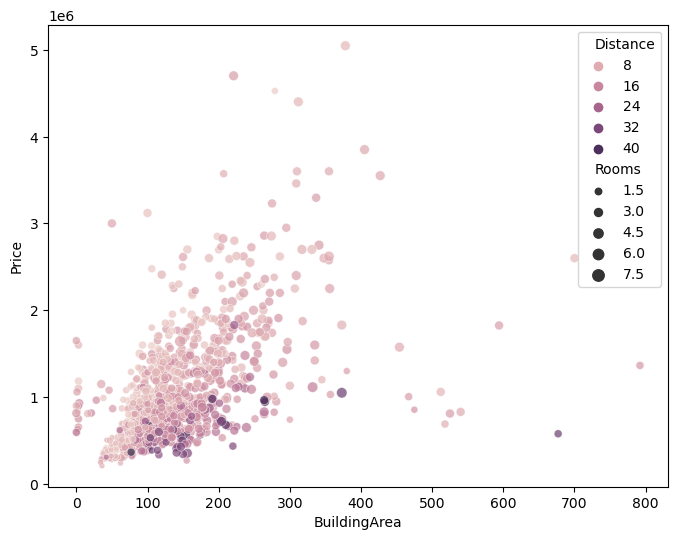

In [44]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(X_train.shape[0]), size=2000, replace=False)
plt.figure(figsize = (8, 6))
sns.scatterplot(x='BuildingArea', y=y_train, size='Rooms', hue='Distance', data=X_train.iloc[random_subset], alpha=0.7)

Из диаграммы легко видеть, что чем больше площадь здания и чем ближе оно к центру, тем выше цена. Между площадью жилья и количеством комнат есть ожидаемая корреляция.

Выведем матрицу корреляции для количественных признаков. Перед этим приводим все числовые признаки к типу float, потому что данные еще не очищались от пропущенных значений и матрица корреляции будет строится с NaN только если все числовые признаки типа float. Также объединим X_train с y_train, чтобы посмотреть на зависимость цены от остальных признаков.

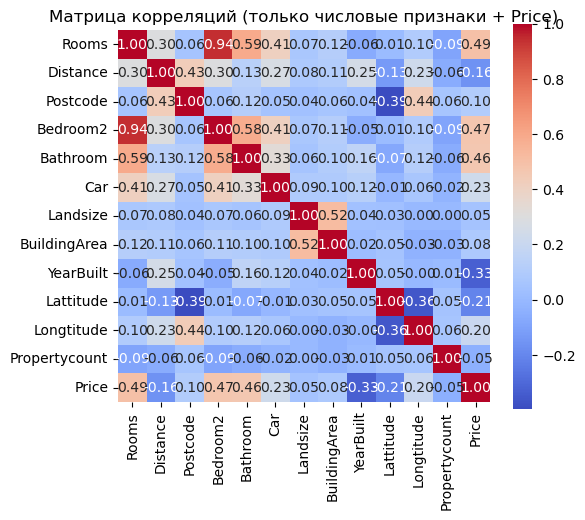

In [45]:
train_df = X_train.copy()
train_df['Price'] = y_train
numeric_df = train_df.select_dtypes(include=['number'])
numeric_df = numeric_df.astype('float64')


corr_mat = numeric_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляций (только числовые признаки + Price)')
plt.show()

Видим, что количество комнат очень сильно коррелирует с количеством спален и ванных комнат, которые также коррелируют между собой. Наблюдается также небольшая зависимость почтового индекса от расстояния до центра и от географическогой долготы(при этом с широтой корреляция нулевая, из чего можно сделать вывод, даже не смотря на карту Мельбурна, что город располагается (растянут) по одной широте). Площадь жилья коррелирует с размерами участка. Цена ожидаемо зависит от количества комнат, при этом она очень слабо зависит от года постройки.

Выведем коэффициенты корреляции больше 0.5

In [46]:
corr_mat > 0.5

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Price
Rooms,True,False,False,True,True,False,False,False,False,False,False,False,False
Distance,False,True,False,False,False,False,False,False,False,False,False,False,False
Postcode,False,False,True,False,False,False,False,False,False,False,False,False,False
Bedroom2,True,False,False,True,True,False,False,False,False,False,False,False,False
Bathroom,True,False,False,True,True,False,False,False,False,False,False,False,False
Car,False,False,False,False,False,True,False,False,False,False,False,False,False
Landsize,False,False,False,False,False,False,True,True,False,False,False,False,False
BuildingArea,False,False,False,False,False,False,True,True,False,False,False,False,False
YearBuilt,False,False,False,False,False,False,False,False,True,False,False,False,False
Lattitude,False,False,False,False,False,False,False,False,False,True,False,False,False


In [47]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

Rooms     Bedroom2        0.940314
          Bathroom        0.591405
Bedroom2  Bathroom        0.582317
Landsize  BuildingArea    0.516363
dtype: float64

Уберем столбец Bedroom2, а Rooms и Bathroom объединим

In [48]:
X_train = X_train.assign(TotalRooms = X_train['Rooms'] + X_train['Bathroom'])
X_test = X_test.assign(TotalRooms = X_test['Rooms'] + X_test['Bathroom'])

In [49]:
X_train = X_train.drop('Bedroom2', axis=1)
X_test = X_test.drop('Bedroom2', axis=1)
X_train = X_train.drop('Rooms', axis=1)
X_test = X_test.drop('Rooms', axis=1)
X_train = X_train.drop('Bathroom', axis=1)
X_test = X_test.drop('Bathroom', axis=1)

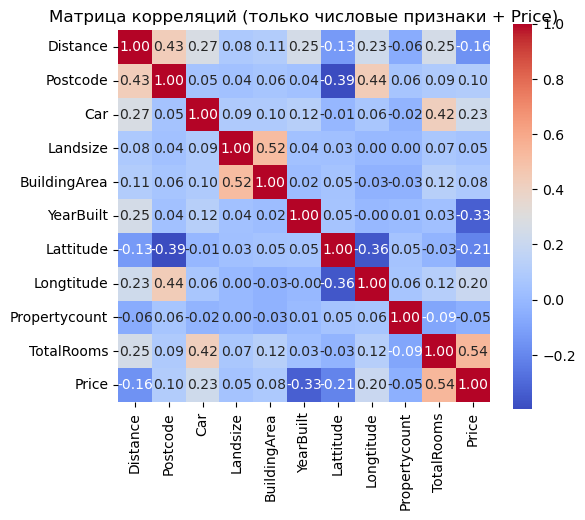

In [50]:
train_df = X_train.copy()
train_df['Price'] = y_train
numeric_df = train_df.select_dtypes(include=['number'])
numeric_df = numeric_df.astype('float64')


corr_mat = numeric_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляций (только числовые признаки + Price)')
plt.show()

Для обнаружения выбросов удобно использовать бокс-диаграмму.

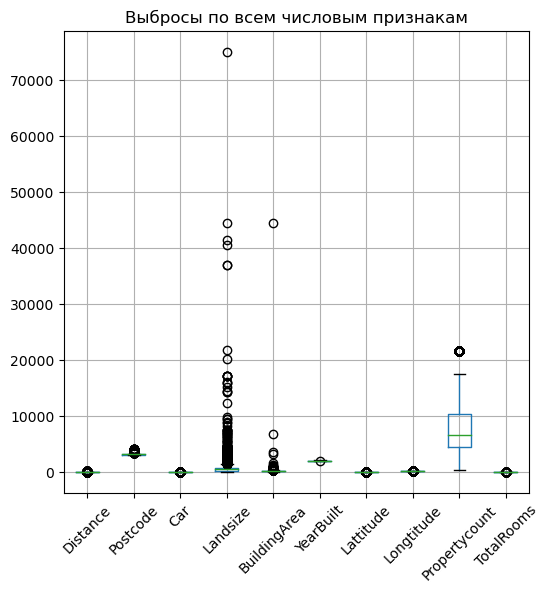

In [51]:
numeric_cols = X_train.select_dtypes(include=['number']).columns

plt.figure(figsize=(6, 6))
X_train[numeric_cols].boxplot()
plt.title('Выбросы по всем числовым признакам')
plt.xticks(rotation=45)
plt.show()

Очень большие выбросы у признаков размер участка, жилая площадь и количество объектов недвижимости в районе. Удалим все строки в таблице, в которых значения выходят за пределы квантелей 0.005 и 0.995

In [52]:
rows_to_drop = X_train[
    (X_train['Landsize'] < X_train['Landsize'].quantile(0.005)) | (X_train['Landsize'] > X_train['Landsize'].quantile(0.995)) | 
    (X_train['BuildingArea']  < X_train['BuildingArea' ].quantile(0.005)) | (X_train['BuildingArea']  > X_train['BuildingArea' ].quantile(0.995))| 
    (X_train['Propertycount']  < X_train['Propertycount' ].quantile(0.005)) | (X_train['Propertycount']  > X_train['Propertycount' ].quantile(0.995))].index
X_train = X_train.drop(rows_to_drop)
y_train = y_train.drop(rows_to_drop)

In [53]:
rows_to_drop

Index([ 3944, 13411, 11389,  9875,  8241,  6880,  2684,  6877, 13370, 13389,
       ...
         770, 13101,  7404, 12249,  5592,  7408,  1484, 10173,  6873,  3073],
      dtype='int64', length=154)

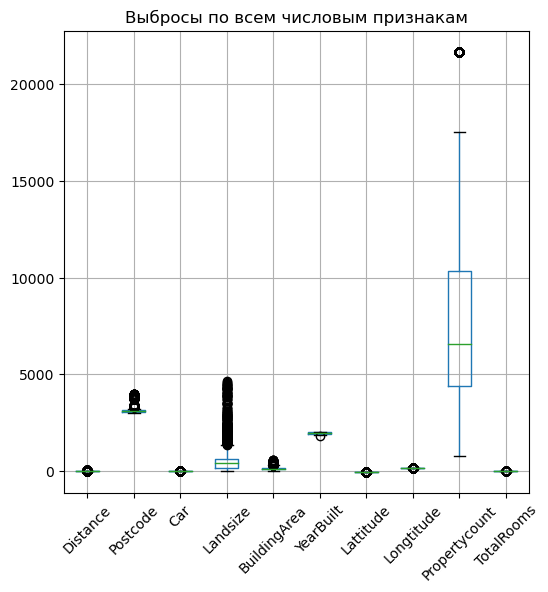

In [54]:
plt.figure(figsize=(6, 6))
X_train[numeric_cols].boxplot()
plt.title('Выбросы по всем числовым признакам')
plt.xticks(rotation=45)
plt.show()

**4. Заполнение пропущенных значений**

Посмотрим сколько пропущенных значений в каждом столбце матрицы

In [55]:
X_train.isna().sum()

Suburb              0
Type                0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Car                48
Landsize            0
BuildingArea     5081
YearBuilt        4237
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
street_type         0
TotalRooms          0
dtype: int64

In [56]:
X_test.isna().sum()

Suburb              0
Type                0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Car                12
Landsize            0
BuildingArea     1321
YearBuilt        1089
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
street_type         0
TotalRooms          0
dtype: int64

Заполним медианами пропущенные значения в столбцах, соответствующих числовым признакам.

In [57]:
numeric_cols = X_train.select_dtypes(include=['number']).columns

numeric_medians = X_train[numeric_cols].median()
X_train[numeric_cols] = X_train[numeric_cols].fillna(numeric_medians)
X_test[numeric_cols] = X_test[numeric_cols].fillna(numeric_medians)

In [58]:
X_test.isna().sum()

Suburb           0
Type             0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
street_type      0
TotalRooms       0
dtype: int64

**5. Обработка категориальных признаков**

Закодируем теперь категориальные признаки. Применим one-hot-encoding

In [59]:
from sklearn.preprocessing import OneHotEncoder

In [60]:
categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()

ohe = OneHotEncoder(
    handle_unknown='ignore',  
    sparse_output=False)

ohe.fit(X_train[categorical_columns])

X_train_cat_ohe = ohe.transform(X_train[categorical_columns])
X_test_cat_ohe = ohe.transform(X_test[categorical_columns])

ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

X_train_cat_df = pd.DataFrame(X_train_cat_ohe, columns=ohe_feature_names, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat_ohe, columns=ohe_feature_names, index=X_test.index)

numerical_columns = [col for col in X_train.columns if col not in categorical_columns]

X_train = pd.concat([X_train[numerical_columns], X_train_cat_df], axis=1)
X_test = pd.concat([X_test[numerical_columns], X_test_cat_df], axis=1)

In [61]:
min_date = X_train['Date'].min()

X_train['DaysSinceStart'] = (X_train['Date'] - min_date).dt.days
X_test['DaysSinceStart'] = (X_test['Date'] - min_date).dt.days

X_train = X_train.drop('Date', axis=1)
X_test = X_test.drop('Date', axis=1)

**6.Стандартизация данных**

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
numerical_columns = ['Postcode','TotalRooms', 'Distance', 'Car',
                     'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude',
                     'DaysSinceStart', 'Propertycount']

scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [64]:
X_train.describe()

,Distance,Postcode,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,TotalRooms,...,street_type_Ct,street_type_Dr,street_type_Grove,street_type_La,street_type_Other,street_type_Parade,street_type_Pl,street_type_Rd,street_type_St,DaysSinceStart
count,1.071000e+04,1.071000e+04,1.071000e+04,1.071000e+04,1.071000e+04,1.071000e+04,1.071000e+04,1.071000e+04,1.071000e+04,1.071000e+04,...,10710.000000,10710.000000,10710.000000,10710.000000,10710.000000,10710.000000,10710.000000,10710.000000,10710.000000,1.071000e+04
mean,1.114577e-16,7.052352e-16,-9.852063e-17,4.644070e-17,1.320243e-16,-2.377100e-15,-6.963153e-14,-6.076517e-14,-4.644070e-17,-8.093951e-17,...,0.045378,0.032773,0.023156,0.005135,0.017647,0.016340,0.011951,0.207190,0.589076,-1.025013e-16
std,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,...,0.208142,0.178051,0.150406,0.071481,0.131671,0.126785,0.108673,0.405311,0.492025,1.000047e+00
min,-1.727703e+00,-1.147130e+00,-1.671295e+00,-1.060841e+00,-2.412339e+00,-4.826356e+00,-4.645407e+00,-5.423998e+00,-1.534979e+00,-2.353199e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.266196e+00
25%,-6.841637e-01,-6.457139e-01,-6.319519e-01,-6.589687e-01,-2.251226e-01,-2.437100e-01,-5.967535e-01,-6.277338e-01,-7.055187e-01,-9.956572e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.691826e-01
50%,-1.538403e-01,-2.315006e-01,4.073916e-01,-6.661328e-02,-1.522154e-01,1.088012e-01,8.801628e-02,4.609131e-02,-2.101815e-01,-3.168864e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.909407e-01
75%,4.962336e-01,4.552214e-01,4.073916e-01,4.490844e-01,-7.930821e-02,2.850569e-01,6.615269e-01,6.067978e-01,6.529895e-01,3.618843e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.049012e-01
max,6.381113e+00,9.502512e+00,8.722140e+00,9.757195e+00,7.758216e+00,1.800855e+00,5.090647e+00,5.115511e+00,3.248694e+00,7.828362e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.467416e+00


**7. - 8. Запускаем регрессоры, считаем ошибки**

Начнем с самой простой модели - вдруг хватит ее?

In [65]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [66]:
y_train_predict = lr_model.predict(X_train)

In [67]:
y_test_predict  = lr_model.predict(X_test)

In [68]:
from sklearn.metrics import mean_squared_error, r2_score

MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test  = r2_score(y_test,  y_test_predict)

MSE_train, MSE_test, R2_train, R2_test

(127741734767.84042,
 1089800730061.5188,
 0.6900847556554116,
 -1.7436120843969278)

In [69]:
lr_model.score(X_test, y_test)

-1.7436120843969278

Видим, что модель переобучилась (обучающие данные она запомнила, но вывести зависимость не смогла, то есть отрицательный коэффициент указывает на то, что нам выгоднее просто брать среднее, чем предсказание от модели). Это было довольно ожидаемо, так как линейная регрессия - очень простая можель, а также соотношение числа элементов в датасете и число признаков после кодирования очень плохое.

Попробуем более сложную модель

In [70]:
from sklearn import ensemble
rf_model = ensemble.RandomForestRegressor(n_estimators = 100)
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [71]:
y_train_predict = rf_model.predict(X_train)
y_test_predict  = rf_model.predict(X_test)

In [72]:
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)
np.sqrt(MSE_train), np.sqrt(MSE_test)

(107114.11226218958, 260323.37330228605)

In [73]:
rf_model.score(X_train, y_train)

0.9721642123281244

In [74]:
rf_model.score(X_test, y_test)

0.8293909993407553

Она обучилась значительно лучше, рассмотрим снова, как в первом случае, линейную модель, но с регуляризацией.

In [91]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=10.0)

In [92]:
model.fit(X_train, y_train)

Ridge(alpha=10.0)

In [93]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

In [94]:
model.score(X_train, y_train)

0.6891925924583979

In [95]:
model.score(X_test, y_test)

-1.7384365750213195

Снова видим сильное переобучение, значит, линейные модели, скорее всего, не справляются с такой зависимостью в данных.

Датасет не самый лучший, так как 13тыс объектов - довольно-таки мало, с учетом того, что даже с хорошей предобработкой остается около 200 признаков (после кодировки с OHE).